# Dataset : News Headlines Dataset For Sarcasm Detection

In [1]:
%pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import opendatasets as od
import pandas as pd

In [3]:
od.download('https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection')

Skipping, found downloaded files in ".\news-headlines-dataset-for-sarcasm-detection" (use force=True to force download)


In [4]:
data = pd.read_json('news-headlines-dataset-for-sarcasm-detection\Sarcasm_Headlines_Dataset_v2.json', lines=True) #import data json for each line

In [5]:
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


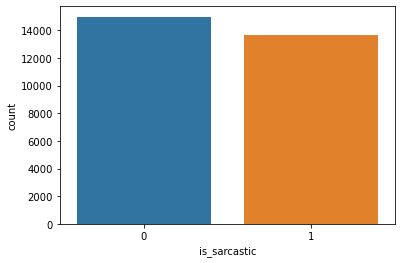

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data['is_sarcastic'])

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data['headline'],data['is_sarcastic'],test_size=0.3,random_state=100)

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
token = Tokenizer(num_words =500,oov_token='<OOV>')
token.fit_on_texts(x_train)
training_sequences = token.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen=100,padding='post',truncating='post')

testing_sequences = token.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=100,padding='post',truncating='post')


## Deep Learning Approach

In [42]:
import numpy as np
train_data = np.array(training_padded)
train_labels = np.asarray(y_train)
test_data = np.array(testing_padded)
test_labels = np.asarray(y_test)



In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM,Bidirectional,GRU
from keras.callbacks import EarlyStopping

In [73]:
model = Sequential()
model.add(Embedding(500,100,input_length=100))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout = 0.2 , dropout = 0.2,return_sequences = True)))
model.add(Bidirectional(GRU(units=64, recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data,train_labels,epochs=20,validation_data=(test_data,test_labels),callbacks=[EarlyStopping(monitor='val_loss', restore_best_weights=True,patience=2)])

Train on 20033 samples, validate on 8586 samples
Epoch 1/20
20033/20033 [==============================] - 218s 11ms/step - loss: 0.5683 - accuracy: 0.7661 - val_loss: 0.4087 - val_accuracy: 0.8119
Epoch 2/20
20033/20033 [==============================] - 219s 11ms/step - loss: 0.3901 - accuracy: 0.8124 - val_loss: 0.3964 - val_accuracy: 0.8166
Epoch 3/20
20033/20033 [==============================] - 214s 11ms/step - loss: 0.3727 - accuracy: 0.8231 - val_loss: 0.3900 - val_accuracy: 0.8130
Epoch 4/20
20033/20033 [==============================] - 220s 11ms/step - loss: 0.3635 - accuracy: 0.8301 - val_loss: 0.3903 - val_accuracy: 0.8141
Epoch 5/20
20033/20033 [==============================] - 222s 11ms/step - loss: 0.3559 - accuracy: 0.8317 - val_loss: 0.3887 - val_accuracy: 0.8153
Epoch 6/20
20033/20033 [==============================] - 220s 11ms/step - loss: 0.3533 - accuracy: 0.8354 - val_loss: 0.3880 - val_accuracy: 0.8232
Epoch 7/20
20033/20033 [==============================] -

In [108]:
from sklearn.metrics import confusion_matrix
pred = model.predict(test_data)
con_mat = confusion_matrix(test_labels,pred.round())
con_mat

array([[3780,  757],
       [ 758, 3291]], dtype=int64)

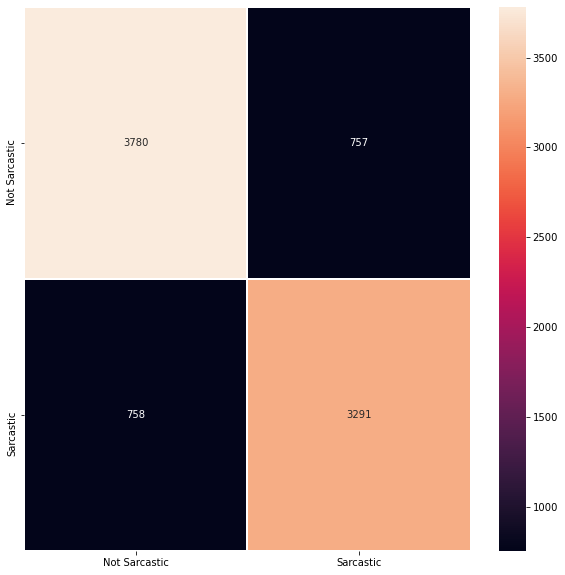

In [78]:
cm = pd.DataFrame(con_mat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(con_mat , linewidth = 1 , annot = True, fmt='d' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

## Prediction

In [163]:
headline_test = data.headline.sample()
result_test = data.is_sarcastic[data.headline == headline_test.iloc[0]].iloc[0]
pred_sequences = token.texts_to_sequences(headline_test)
pred_padded = pad_sequences(pred_sequences,maxlen=100,padding='post',truncating='post')
pred_padded = np.array(pred_padded)
pred_result = model.predict(pred_padded)
pred_result = pred_result[0][0].round().astype(int)
print("News              : "+headline_test.iloc[0])
print("Is it Sarcastic ? : "+("yes" if result_test == 1 else "no"))
print("Predicted Value   : "+("yes" if pred_result == 1 else "no"))

News              : who owns the keys to your apple device? (hint: it may not be you)
Is it Sarcastic ? : no
Predicted Value   : no
